## siamese network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

2022-11-29 21:38:02.219263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 21:38:02.873947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 21:38:02.873994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 21:38:03.011769: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 21:38:05.971532: W tensorflow/stream_executor/platform/de

In [14]:
target_shape = (400,400)

In [2]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [3]:
def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [43]:
anchor_images_path = "original_sg"
positive_images_path = "snoise_sg"

In [44]:
anchor_images = [str(anchor_images_path+'/'+f) for f in os.listdir(anchor_images_path)][0:1000]
positive_images = [str(positive_images_path+'/'+f) for f in os.listdir(positive_images_path)][0:1000]

In [45]:
anchor_images

['original_sg/s_1922.jpg',
 'original_sg/s_943.jpg',
 'original_sg/s_5090.jpg',
 'original_sg/s_5864.jpg',
 'original_sg/s_5708.jpg',
 'original_sg/s_2751.jpg',
 'original_sg/s_3373.jpg',
 'original_sg/s_375.jpg',
 'original_sg/s_3165.jpg',
 'original_sg/s_3509.jpg',
 'original_sg/s_2388.jpg',
 'original_sg/s_3074.jpg',
 'original_sg/s_2408.jpg',
 'original_sg/s_3310.jpg',
 'original_sg/s_5946.jpg',
 'original_sg/s_1731.jpg',
 'original_sg/s_6423.jpg',
 'original_sg/s_1192.jpg',
 'original_sg/s_4343.jpg',
 'original_sg/s_4649.jpg',
 'original_sg/s_2327.jpg',
 'original_sg/s_4609.jpg',
 'original_sg/s_6032.jpg',
 'original_sg/s_4267.jpg',
 'original_sg/s_2590.jpg',
 'original_sg/s_4034.jpg',
 'original_sg/s_5522.jpg',
 'original_sg/s_1323.jpg',
 'original_sg/s_6405.jpg',
 'original_sg/s_2766.jpg',
 'original_sg/s_6249.jpg',
 'original_sg/s_753.jpg',
 'original_sg/s_5764.jpg',
 'original_sg/s_379.jpg',
 'original_sg/s_3873.jpg',
 'original_sg/s_704.jpg',
 'original_sg/s_2019.jpg',
 'orig

In [46]:
positive_images

['snoise_sg/s_1922.jpg',
 'snoise_sg/s_943.jpg',
 'snoise_sg/s_5090.jpg',
 'snoise_sg/s_5864.jpg',
 'snoise_sg/s_5708.jpg',
 'snoise_sg/s_2751.jpg',
 'snoise_sg/s_3373.jpg',
 'snoise_sg/s_375.jpg',
 'snoise_sg/s_3165.jpg',
 'snoise_sg/s_3509.jpg',
 'snoise_sg/s_2388.jpg',
 'snoise_sg/s_3074.jpg',
 'snoise_sg/s_2408.jpg',
 'snoise_sg/s_3310.jpg',
 'snoise_sg/s_5946.jpg',
 'snoise_sg/s_1731.jpg',
 'snoise_sg/s_6423.jpg',
 'snoise_sg/s_1192.jpg',
 'snoise_sg/s_4343.jpg',
 'snoise_sg/s_4649.jpg',
 'snoise_sg/s_2327.jpg',
 'snoise_sg/s_4609.jpg',
 'snoise_sg/s_6032.jpg',
 'snoise_sg/s_4267.jpg',
 'snoise_sg/s_2590.jpg',
 'snoise_sg/s_4034.jpg',
 'snoise_sg/s_5522.jpg',
 'snoise_sg/s_1323.jpg',
 'snoise_sg/s_6405.jpg',
 'snoise_sg/s_2766.jpg',
 'snoise_sg/s_6249.jpg',
 'snoise_sg/s_753.jpg',
 'snoise_sg/s_5764.jpg',
 'snoise_sg/s_379.jpg',
 'snoise_sg/s_3873.jpg',
 'snoise_sg/s_704.jpg',
 'snoise_sg/s_2019.jpg',
 'snoise_sg/s_5469.jpg',
 'snoise_sg/s_2831.jpg',
 'snoise_sg/s_1302.jpg',
 'sno

In [47]:
image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

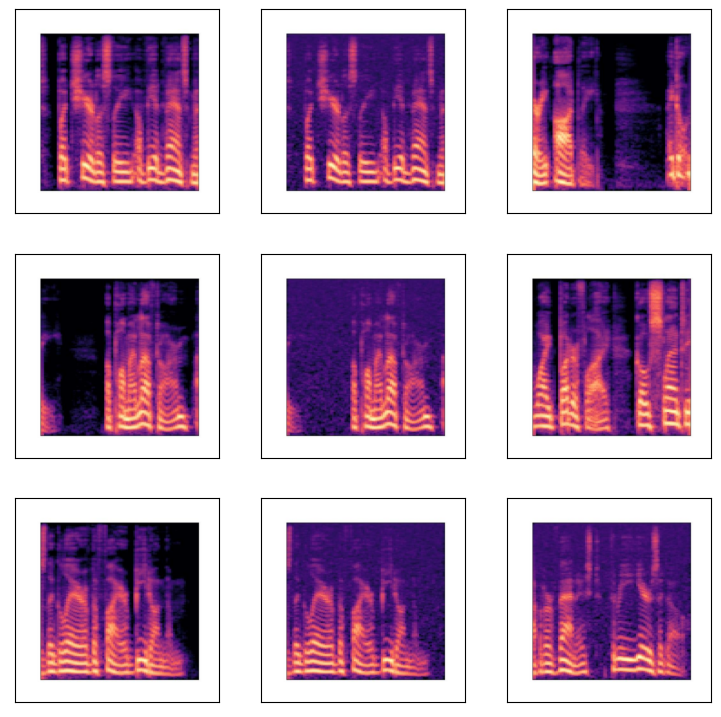

In [48]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [49]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [50]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset,batch_size=256, epochs=10, validation_data=val_dataset)